# Import all the necessary packages

In [1]:
from enum import IntEnum
import time
import jsonrpclib
import subprocess
from subprocess import PIPE, Popen
from threading  import Thread
import sys
import re
from collections import OrderedDict

import PySimpleGUI as sg

from gym import Env, error, spaces, utils
from stable_baselines3 import DQN, PPO, A2C, TD3, SAC
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.env_checker import check_env
import numpy as np

import os
import requests
import shutil
import tempfile
import xml.etree.ElementTree as ET
from io import StringIO, BytesIO

import cv2
import numpy as np
import torch
from PIL import Image
from IPython.display import clear_output
import gym
from cv2 import QRCodeDetector

import olympe
from olympe.messages.ardrone3.Piloting import TakeOff, Landing, moveBy, PCMD, moveTo
from olympe.messages.ardrone3.PilotingState import FlyingStateChanged, PositionChanged, GpsLocationChanged, moveToChanged
from olympe.enums.ardrone3.PilotingState import FlyingStateChanged_State as FlyingState
from olympe.messages.ardrone3.GPSSettingsState import GPSFixStateChanged, HomeChanged
from olympe.messages.gimbal import set_target, attitude
from olympe.messages.camera import (
    set_camera_mode,
    set_photo_mode,
    take_photo,
    photo_progress,
)
from olympe.media import (
    media_created,
    resource_created,
    media_removed,
    resource_removed,
    resource_downloaded,
    indexing_state,
    delete_media,
    download_media,
    download_media_thumbnail,
    MediaEvent,
)

from pynput.keyboard import Listener, Key, KeyCode
from collections import defaultdict

olympe.log.update_config({
    "loggers": {
        "olympe": {
                "handlers": []
            }
        },
        "ulog": {
            "level": "OFF",
            "handlers": [],
        }
})

# Define the constants

In [2]:
DRONE_IP = os.environ.get("DRONE_IP", "10.202.0.1")
DRONE_MEDIA_PORT = os.environ.get("DRONE_MEDIA_PORT", "80")

ANAFI_URL = "http://{}/".format(DRONE_IP)
ANAFI_MEDIA_API_URL = ANAFI_URL + "api/v1/media/medias/"

img = None

# Define the classes

## Action

In [3]:
class Action:
    def __init__(self, drone):
        self.drone = drone
        self.home = self.drone.get_state(GpsLocationChanged)
        
        self.current_cell = self._get_cell(13)
        self.invalid_left_cells = [1, 6, 11, 16, 21]
        self.invalid_forward_cells = [1, 2, 3, 4, 5]
        self.invalid_right_cells = [5, 10, 15, 20, 25]
        self.invalid_backward_cells = [21, 22, 23, 24, 25]
        
        self.Move = IntEnum(
            'MOVE',
            'FORWARD BACKWARD LEFT RIGHT FORWARD_LEFT FORWARD_RIGHT BACKWARD_LEFT BACKWARD_RIGHT HOVER',
            start=0
        )
        
    def take_action(self, action):
        next_cell_id = self._get_next_cell_id(action)
        next_cell = self._get_cell(next_cell_id)
        
        old_cell_id, new_cell_id = self.current_cell["id"], next_cell["id"]
        if old_cell_id == new_cell_id: 
            return old_cell_id, new_cell_id, self._get_action_name(action)
        
        self._move_to_cell(next_cell)
        
        self.current_cell = next_cell
        
        return old_cell_id, new_cell_id, self._get_action_name(action)
        
    def reset(self):
        next_cell = self._get_cell(13)
        self._move_to_cell(next_cell)
        
        old_cell_id, new_cell_id = self.current_cell["id"], next_cell["id"]
        self.current_cell = next_cell
        
        return old_cell_id, new_cell_id
    
    def _get_cell(self, cell_id):
        return self._cell_coords[cell_id - 1]
    
    def _get_action_name(self, action):
        direction = str(self.Move(action)).split(".")[1].capitalize()
        return "Moving " + direction if "hover" not in direction.lower() else "Hovering"
    
    def _move_to_cell(self, next_cell):        
        self.drone(
            moveTo(next_cell["latitude"],  next_cell["longitude"], next_cell["altitude"], "HEADING_DURING", 90.0)
            >> moveToChanged(status="DONE", _timeout=15)
        ).wait()
    
    def _get_next_cell_id(self, action):
        if action == self.Move.HOVER:
            return self.current_cell["id"]
        elif action == self.Move.LEFT:
            if self.current_cell["id"] in self.invalid_left_cells:
                return self.current_cell["id"]
            next_cell_id = self.current_cell["id"] - 1
        elif action == self.Move.RIGHT:
            if self.current_cell["id"] in self.invalid_right_cells:
                return self.current_cell["id"]
            next_cell_id = self.current_cell["id"] + 1
        elif action == self.Move.FORWARD:
            if self.current_cell["id"] in self.invalid_forward_cells:
                return self.current_cell["id"]
            next_cell_id = self.current_cell["id"] - 5
        elif action == self.Move.BACKWARD:
            if self.current_cell["id"] in self.invalid_backward_cells:
                return self.current_cell["id"]
            next_cell_id = self.current_cell["id"] + 5
        elif action == self.Move.FORWARD_RIGHT:
            if self.current_cell["id"] in self.invalid_forward_cells + self.invalid_right_cells:
                return self.current_cell["id"]
            next_cell_id = self.current_cell["id"] - 4
        elif action == self.Move.FORWARD_LEFT:
            if self.current_cell["id"] in self.invalid_forward_cells + self.invalid_left_cells:
                return self.current_cell["id"]
            next_cell_id = self.current_cell["id"] - 6
        elif action == self.Move.BACKWARD_RIGHT:
            if self.current_cell["id"] in self.invalid_backward_cells + self.invalid_right_cells:
                return self.current_cell["id"]
            next_cell_id = self.current_cell["id"] + 6
        elif action == self.Move.BACKWARD_LEFT:
            if self.current_cell["id"] in self.invalid_backward_cells + self.invalid_left_cells:
                return self.current_cell["id"]
            next_cell_id = self.current_cell["id"] + 4
            
        return next_cell_id
    
    @property
    def _cell_coords(self):
        altitude = 6.0
        dlong = 6.8e-5 # in degrees == 5 meters along x-axis (forward[+]-backward[-])
        dlat = 7.2e-5 # in degrees == 8 meters along y-axis (left[+]-right[-])
        
        home_lat = self.home["latitude"]
        home_long = self.home["longitude"]
        
        return [
            # cell no. 1
            OrderedDict([('id', 1),
                         ('latitude', home_lat + 2 * dlat),
                         ('longitude', home_long + 2 * dlong),
                         ('altitude', altitude)]),
            # cell no. 2
            OrderedDict([('id', 2),
                         ('latitude', home_lat + 1 * dlat),
                         ('longitude', home_long + 2 * dlong),
                         ('altitude', altitude)]),
            # cell no. 3
            OrderedDict([('id', 3),
                         ('latitude', home_lat + 0 * dlat),
                         ('longitude', home_long + 2 * dlong),
                         ('altitude', altitude)]),
            # cell no. 4
            OrderedDict([('id', 4),
                         ('latitude', home_lat + -1 * dlat),
                         ('longitude', home_long + 2 * dlong),
                         ('altitude', altitude)]),
            # cell no. 5
            OrderedDict([('id', 5),
                         ('latitude', home_lat + -2 * dlat),
                         ('longitude', home_long + 2 * dlong),
                         ('altitude', altitude)]),
            # cell no. 6
            OrderedDict([('id', 6),
                         ('latitude', home_lat + 2 * dlat),
                         ('longitude', home_long + 1 * dlong),
                         ('altitude', altitude)]),
            # cell no. 7
            OrderedDict([('id', 7),
                         ('latitude', home_lat + 1 * dlat),
                         ('longitude', home_long + 1 * dlong),
                         ('altitude', altitude)]),
            # cell no. 8
            OrderedDict([('id', 8),
                         ('latitude', home_lat + 0 * dlat),
                         ('longitude', home_long + 1 * dlong),
                         ('altitude', altitude)]),
            # cell no. 9
            OrderedDict([('id', 9),
                         ('latitude', home_lat + -1 * dlat),
                         ('longitude', home_long + 1 * dlong),
                         ('altitude', altitude)]),
            # cell no. 10
            OrderedDict([('id', 10),
                         ('latitude', home_lat + -2 * dlat),
                         ('longitude', home_long + 1 * dlong),
                         ('altitude', altitude)]),
            # cell no. 11
            OrderedDict([('id', 11),
                         ('latitude', home_lat + 2 * dlat),
                         ('longitude', home_long + 0 * dlong),
                         ('altitude', altitude)]),
            # cell no. 12
            OrderedDict([('id', 12),
                         ('latitude', home_lat + 1 * dlat),
                         ('longitude', home_long + 0 * dlong),
                         ('altitude', altitude)]),
            # cell no. 13
            OrderedDict([('id', 13),
                         ('latitude', home_lat + 0 * dlat),
                         ('longitude', home_long + 0 * dlong),
                         ('altitude', altitude)]),
            # cell no. 14
            OrderedDict([('id', 14),
                         ('latitude', home_lat + -1 * dlat),
                         ('longitude', home_long + 0 * dlong),
                         ('altitude', altitude)]),
            # cell no. 15
            OrderedDict([('id', 15),
                         ('latitude', home_lat + -2 * dlat),
                         ('longitude', home_long + 0 * dlong),
                         ('altitude', altitude)]),
            # cell no. 16
            OrderedDict([('id', 16),
                         ('latitude', home_lat + 2 * dlat),
                         ('longitude', home_long + -1 * dlong),
                         ('altitude', altitude)]),
            # cell no. 17
            OrderedDict([('id', 17),
                         ('latitude', home_lat + 1 * dlat),
                         ('longitude', home_long + -1 * dlong),
                         ('altitude', altitude)]),
            # cell no. 18
            OrderedDict([('id', 18),
                         ('latitude', home_lat + 0 * dlat),
                         ('longitude', home_long + -1 * dlong),
                         ('altitude', altitude)]),
            # cell no. 19
            OrderedDict([('id', 19),
                         ('latitude', home_lat + -1 * dlat),
                         ('longitude', home_long + -1 * dlong),
                         ('altitude', altitude)]),
            # cell no. 20
            OrderedDict([('id', 20),
                         ('latitude', home_lat + -2 * dlat),
                         ('longitude', home_long + -1 * dlong),
                         ('altitude', altitude)]),
            # cell no. 21
            OrderedDict([('id', 21),
                         ('latitude', home_lat + 2 * dlat),
                         ('longitude', home_long + -2 * dlong),
                         ('altitude', altitude)]),
            # cell no. 22
            OrderedDict([('id', 22),
                         ('latitude', home_lat + 1 * dlat),
                         ('longitude', home_long + -2 * dlong),
                         ('altitude', altitude)]),
            # cell no. 23
            OrderedDict([('id', 23),
                         ('latitude', home_lat + 0 * dlat),
                         ('longitude', home_long + -2 * dlong),
                         ('altitude', altitude)]),
            # cell no. 24
            OrderedDict([('id', 24),
                         ('latitude', home_lat + -1 * dlat),
                         ('longitude', home_long + -2 * dlong),
                         ('altitude', altitude)]),
            # cell no. 25
            OrderedDict([('id', 25),
                         ('latitude', home_lat + -2 * dlat),
                         ('longitude', home_long + -2 * dlong),
                         ('altitude', altitude)]),
            ]
        
    def __len__(self):
        return len(self.Move)

## State

In [4]:
class State:
    def __init__(self, drone):
        self.drone = drone

## Reward

In [5]:
class Reward:
    def __init__(self, drone):
        self.drone = drone

## Drone

In [6]:
class Drone:
    def __init__(self, drone_ip, num_targets, max_timestep):
        self.drone = olympe.Drone(drone_ip)
        self.drone.connect()
        
        self.drone(GPSFixStateChanged(_policy = 'wait'))
        self._takeoff()
        self._setup_camera()

        self.state = State(self.drone)
        self.reward = Reward(self.drone)
        self.action = Action(self.drone)
        self.decoder = QRCodeDetector()
        
        self.num_targets = num_targets
        self.max_timestep = max_timestep
        self.timestep = 0
        self.visited_targets = np.zeros(self.num_targets, dtype=bool)
    
    def take_action(self, action):
        old_cell, new_cell, action_name = self.action.take_action(action)
        self.timestep += 1
        detected_targets = self._detect_targets()
        
        reward = self._get_reward(detected_targets) # !!! _get_reward must come before self.visited_targets is changed in _get_state
        state = self._get_state(new_cell, detected_targets) 
        if self.timestep > self.max_timestep or np.all(self.visited_targets):
            done = True
            self.visited_targets[:] = False
            self.timestep = 0
        else:
            done = False
        info = {
            "action": str(action_name), 
            "direction": "Cell " + str(old_cell) + " --> " + "Cell " + str(new_cell)
        }
        
        return state, reward, done, info

    def reset(self):
        old_cell, new_cell = self.action.reset()
        detected_targets = self._detect_targets()
        return self._get_state(new_cell, detected_targets)
    
    def _get_state(self, new_cell, detected_targets):
        # {t, cell_id, [I1, I2, I3, ..., In]}
        
        self.visited_targets[detected_targets] = True
        
        return {
            "timestep": self.timestep,
            "cell_id": new_cell-1,
            "visited_targets": self.visited_targets.copy(),
        }
    
    def _get_reward(self, detected_targets):
        reward_scale = 1
#         print(detected_targets)
        num_new_targets = np.count_nonzero(
            detected_targets & (detected_targets != self.visited_targets)
        )
#         print(num_new_targets)
        return reward_scale * num_new_targets if num_new_targets > 0 else -1
        
    def _detect_targets(self):
        img = self._take_photo()
        img_arr = np.array(img)
        results = self.decoder.detectAndDecodeMulti(img_arr)

        _, retvals, _, _ = results
        
        detected_targets = np.zeros(self.num_targets, dtype=bool)
        
#         print(retvals)
        for val in retvals:
            try:
                detected_targets[int(val)-1] = True
            except (ValueError, IndexError):
                pass

#         print(detected_targets)
        return detected_targets

    def _setup_camera(self):
        assert self.drone.media_autoconnect
        self.drone.media.integrity_check = True
        is_indexed = False
        while not is_indexed:
            is_indexed = self.drone.media(
                indexing_state(state="indexed")
            ).wait(_timeout=5).success()
        
        self.drone(set_camera_mode(cam_id=0, value="photo")).wait()

        assert self.drone(
            set_photo_mode(
                cam_id=0,
                mode="single",
                format= "rectilinear",
                file_format="jpeg",
                # the following are ignored in photo single mode
                burst="burst_14_over_1s",
                bracketing="preset_1ev",
                capture_interval=5.0,
            )
        ).wait().success()

        assert self.drone(
            set_target(
                gimbal_id=0,
                control_mode="position",
                yaw_frame_of_reference="none",
                yaw=0.0,
                pitch_frame_of_reference="absolute",
                pitch=-90.0,
                roll_frame_of_reference="none",
                roll=0.0,
                )
            >> attitude(
                pitch_absolute=-90.0, _policy="wait", _float_tol=(1e-3, 1e-1)
                )
            ).wait(_timeout=20).success()
    
    def _take_photo(self):
        photo_saved = self.drone(photo_progress(result="photo_saved", _policy="wait"))
        self.drone(take_photo(cam_id=0)).wait()
        if not photo_saved.wait(_timeout=30).success():
            assert False, "take_photo timedout"
            
        # get the bytes of the image
        media_id = photo_saved.received_events().last().args["media_id"]
        for _ in range(5):
            media_info_response = requests.get(ANAFI_MEDIA_API_URL + media_id, timeout=10)
            if media_info_response.status_code == 200:
                break
        media_info_response.raise_for_status()
        
        resource = media_info_response.json()["resources"][0]
        image_response = requests.get(ANAFI_URL + resource["url"], stream=True)
        image_response.raise_for_status()
        
        global img
        img = Image.open(BytesIO(image_response.content))
        
        # delete the image stored on the drone
        delete_media(media_id, _timeout=10).wait()
        
        return img
    
    def _takeoff(self):
        takeoff_success = self._success_if_takeoff()
        if not takeoff_success:
            print("Retrying taking off...")
            takeoff_success = self._success_if_takeoff()
    
    def _success_if_takeoff(self):
        return self.drone(
                FlyingStateChanged(state="hovering")
                | (TakeOff() & FlyingStateChanged(state="hovering"))
            ).wait(10).success()
        
    def _land(self):
        self.drone(PCMD(1, 0, 0, 0, 0, 0) >> FlyingStateChanged(state="hovering", _timeout=5)).wait()
        assert self.drone(Landing() >> FlyingStateChanged(state="landed")).wait().success()
        
    def __del__(self):
        self._land()
        self.drone.disconnect()
        del state
        del reward
        del action

## Simulation

In [7]:
class Simulation:
    def __init__(self):
        pass
    
    @staticmethod
    def disable_battery():
        sphinx = jsonrpclib.Server('http://127.0.0.1:8383')
        sphinx.SetParam(machine='anafi4k', 
                         object='lipobattery/lipobattery', 
                         parameter='discharge_speed_factor', 
                         value='0')
    
    @staticmethod
    def cease_targets():
        f = open("../plugins/moving_target/toggle_movement.txt", "w")
        f.write("0")
        f.close()
    
    @staticmethod
    def move_targets():
        f = open("../plugins/moving_target/toggle_movement.txt", "w")
        f.write("1")
        f.close()
        
    @staticmethod
    def reset_targets(release=False):
        f = open("../plugins/moving_target/reset_position.txt", "w")
        if not release:
            f.write("1")
        else:
            f.write("0")
        f.close()
        

# Helper classes

In [8]:
class EnvManager():
    def __init__(self):
        pass
    
    def store_state(self, state):
        pass
    
    def store_reward(self, state):
        pass
    
    def get_last_state(self):
        pass

class FlightListener(olympe.EventListener):

    default_queue_size = 100

    def __init__(self, *args, **kwds):
        super().__init__(*args, **kwds)
    
    @olympe.listen_event(media_created())
    def onMediaCreated(self, event, scheduler):
        resource_url = list(event.media.resources.values())[0].url
        image_response = requests.get(ANAFI_URL + resource_url, stream=True)
        image_response.raise_for_status()
        global img
        img = Image.open(BytesIO(image_response.content))

# Define a Gym Environment

In [9]:
class AnafiEnv(Env):
    def __init__(self, num_targets, max_timestep, drone_ip="10.202.0.1"):
        super(AnafiEnv, self).__init__()
        
        Simulation.disable_battery()
        Simulation.cease_targets()
        
        self.agent = Drone(drone_ip, num_targets, max_timestep)
        
        self.action_space = spaces.Discrete(len(self.agent.action))
        self.observation_space = spaces.Dict({
            "timestep": spaces.Discrete(max_timestep),
            "cell_id": spaces.Discrete(25), # spaces.Box(low=1, high=25, shape=(1,), dtype=int),
            "visited_targets": spaces.MultiBinary(num_targets),
        })
        
#         Simulation.move_targets()
    
    def step(self, action):
        obs, reward, done, info = self.agent.take_action(action)
        
        return obs, reward, done, info
    
    def reset(self):
        Simulation.reset_targets()
        return self.agent.reset()
    
    def render(self, mode='human'):
        pass
    
    def close(self):
        Simulation.cease_targets()
        del self.agent

# Run the simulation

In [10]:
def disp_info(action, observation, reward, done, info):
#     clear_output(wait=True)
    print("Action:", info["action"] + ",", info["direction"])
    observation["cell_id"] += 1
    print("State:", observation)
    print("Reward:", reward)
    down_scale = 3
    display(img.resize((img.size[0]//down_scale, img.size[1]//down_scale)))

Action: Moving Backward_left, Cell 13 --> Cell 17
State: {'timestep': 1, 'cell_id': 17, 'visited_targets': array([False, False, False])}
Reward: -1


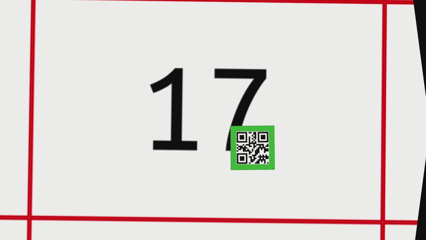

Action: Moving Backward_right, Cell 17 --> Cell 23
State: {'timestep': 2, 'cell_id': 23, 'visited_targets': array([ True,  True, False])}
Reward: 2


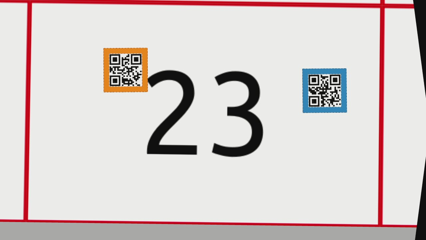

Action: Moving Forward_right, Cell 23 --> Cell 19
State: {'timestep': 3, 'cell_id': 19, 'visited_targets': array([ True,  True,  True])}
Reward: 1


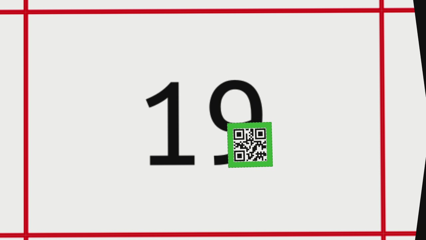

The episode has ended. Resetting environment...
Action: Hovering, Cell 13 --> Cell 13
State: {'timestep': 1, 'cell_id': 13, 'visited_targets': array([False, False, False])}
Reward: -1


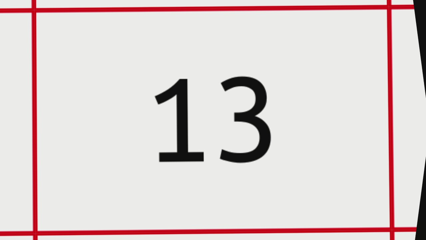

Action: Moving Forward, Cell 13 --> Cell 8
State: {'timestep': 2, 'cell_id': 8, 'visited_targets': array([ True,  True, False])}
Reward: 2


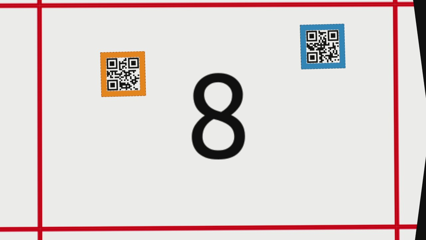

Action: Hovering, Cell 8 --> Cell 8
State: {'timestep': 3, 'cell_id': 8, 'visited_targets': array([ True,  True, False])}
Reward: -1


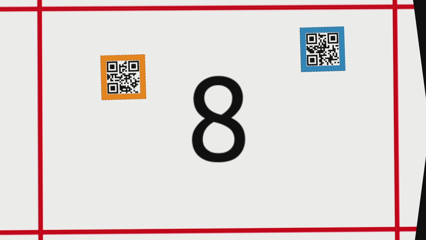

Action: Moving Backward, Cell 8 --> Cell 13
State: {'timestep': 4, 'cell_id': 13, 'visited_targets': array([ True,  True, False])}
Reward: -1


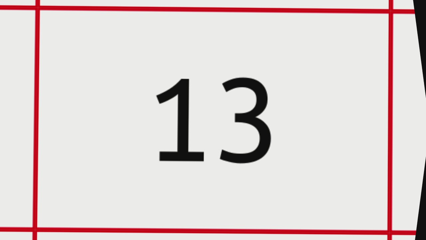

Action: Moving Forward_left, Cell 13 --> Cell 7
State: {'timestep': 5, 'cell_id': 7, 'visited_targets': array([ True,  True,  True])}
Reward: 1


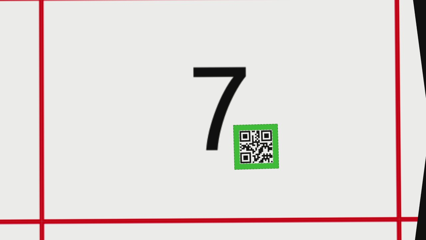

The episode has ended. Resetting environment...


2022-02-10 11:12:29,478 [ERROR] 	ulog - pomp - epoll_ctl(fd=74) err=9(Bad file descriptor)
2022-02-10 11:12:29,484 [ERROR] 	ulog - pomp - epoll_ctl op=2 cb=0x7f13bf6d74e0 userdata=0x7f1300736f90


AssertionError: take_photo timedout

In [11]:
env = AnafiEnv(num_targets=3, max_timestep=10)
observation = env.reset()

for _ in range(1000):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    disp_info(action, observation, reward, done, info)

    if done:
        print("The episode has ended. Resetting environment...")
        observation = env.reset()

env.close()